In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
log_dir = Path("../src/controller/logs/600FPS_0.5Kp_1Kd_64Capacity_16ModelSize_adaptive_v0vrx0")

# Get the parameters from the log directory
experiment_name = log_dir.parts[-1]
sp=experiment_name.split("_")
fps = sp[0][:-3]
kp = sp[1][:-2]
kd = sp[2][:-2]
capacity = sp[3][:-8]
model_size = sp[4][:-9]
print(f"fps: {fps}, kp: {kp}, kd: {kd}, capacity: {capacity}, model_size: {model_size}")

event_acc = EventAccumulator(str(log_dir))
event_acc.Reload()
tags = event_acc.Tags()['scalars']

fps: 600, kp: 0.5, kd: 1, capacity: 64, model_size: 16


In [3]:
framesqueued_tag = [t for t in tags if 'framesqueued' in t]
framesprocessed_tag = [t for t in tags if 'framesprocessed' in t]
replica_tag = [t for t in tags if 'replica' in t]
actual_containers_tag = [t for t in tags if 'running_pods' in t]

In [4]:
def get_data(writer, tags):
    dfs = []
    for tag in tags:
        s = writer.Scalars(tag)
        temp_df = pd.DataFrame(s)
        temp_df['wall_time'] = pd.to_datetime(temp_df['wall_time'], unit='s')
        temp_df['tag'] = tag
        # Set the wall_time column as the index
        temp_df.set_index('wall_time', inplace=True)
        # Select only numeric columns for resampling
        numeric_df = temp_df.select_dtypes(include=['number'])

        # Resample to 5 seconds and calculate the mean
        df_resampled = numeric_df.resample('5s').max()
        df_resampled["diff"] = df_resampled["value"].diff().fillna(0)

        # Reset the index
        df_resampled.reset_index(inplace=True)
        dfs.append(df_resampled)

    # Concatenate all DataFrames in framesprocessed_dfs and select the 'diff' column
    diff_df = pd.concat([df[['wall_time', 'value', 'diff']] for df in dfs], ignore_index=True)
    diff_df.sort_values(by='wall_time', inplace=True)
    diff_df.set_index('wall_time', inplace=True)
    return diff_df

In [5]:
framesprocessed_df = get_data(event_acc, framesprocessed_tag)
framesqueued_df = get_data(event_acc, framesqueued_tag)
replica_df = get_data(event_acc, replica_tag)
actual_containers_df = get_data(event_acc, actual_containers_tag)

In [6]:
replica_df.head()

,value,diff
wall_time,,
2025-03-12 16:53:55,30.0,0.0
2025-03-12 16:54:00,34.0,4.0
2025-03-12 16:54:05,33.0,-1.0
2025-03-12 16:54:10,43.0,10.0
2025-03-12 16:54:15,52.0,9.0


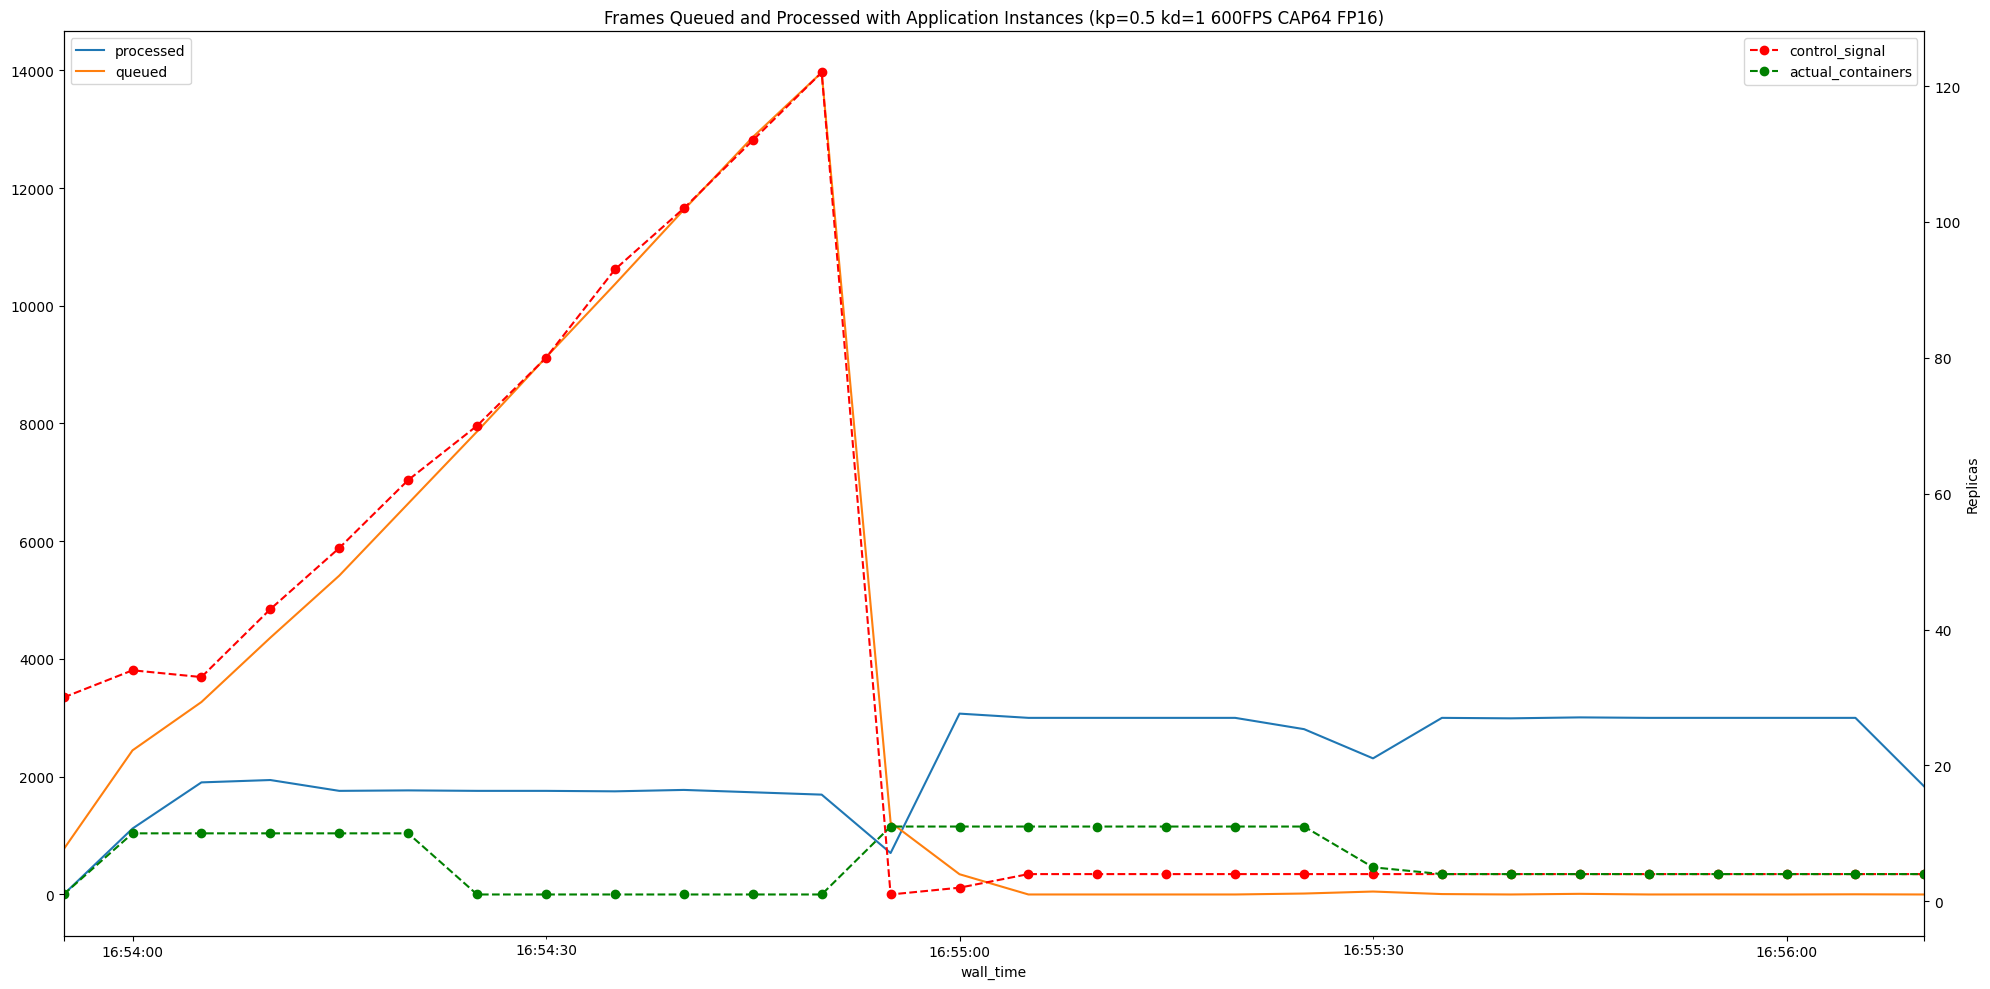

In [7]:
ax = framesprocessed_df.resample('5s').sum().plot(y='diff', title="Frames Processed", figsize=(20, 10), label='processed')
framesqueued_df.resample('5s').sum().plot(ax=ax, y='value', title=f"Frames Queued and Processed with Application Instances (kp={kp} kd={kd} {fps}FPS CAP{capacity} FP{model_size})", figsize=(20, 10), label="queued")
ax2 = ax.twinx()
replica_df["value"].resample('5s').sum().plot(ax=ax2, color='r', marker='o', linestyle='--', figsize=(20, 10), label="control_signal")
actual_containers_df["value"].resample('5s').sum().plot(ax=ax2, color='g', marker='o', linestyle='--', figsize=(20, 10), label="actual_containers")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Replicas')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig(f"{experiment_name}.png")

In [8]:
# Convert timeepoch in dfs to elapsed time
framesprocessed_df['elapsed_time'] = (framesprocessed_df.index - framesprocessed_df.index[0]).total_seconds()
framesprocessed_df.set_index('elapsed_time', inplace=True)
framesqueued_df['elapsed_time'] = (framesqueued_df.index - framesqueued_df.index[0]).total_seconds()
framesqueued_df.set_index('elapsed_time', inplace=True)
replica_df['elapsed_time'] = (replica_df.index - replica_df.index[0]).total_seconds()
replica_df.set_index('elapsed_time', inplace=True)
actual_containers_df['elapsed_time'] = (actual_containers_df.index - actual_containers_df.index[0]).total_seconds()
actual_containers_df.set_index('elapsed_time', inplace=True)



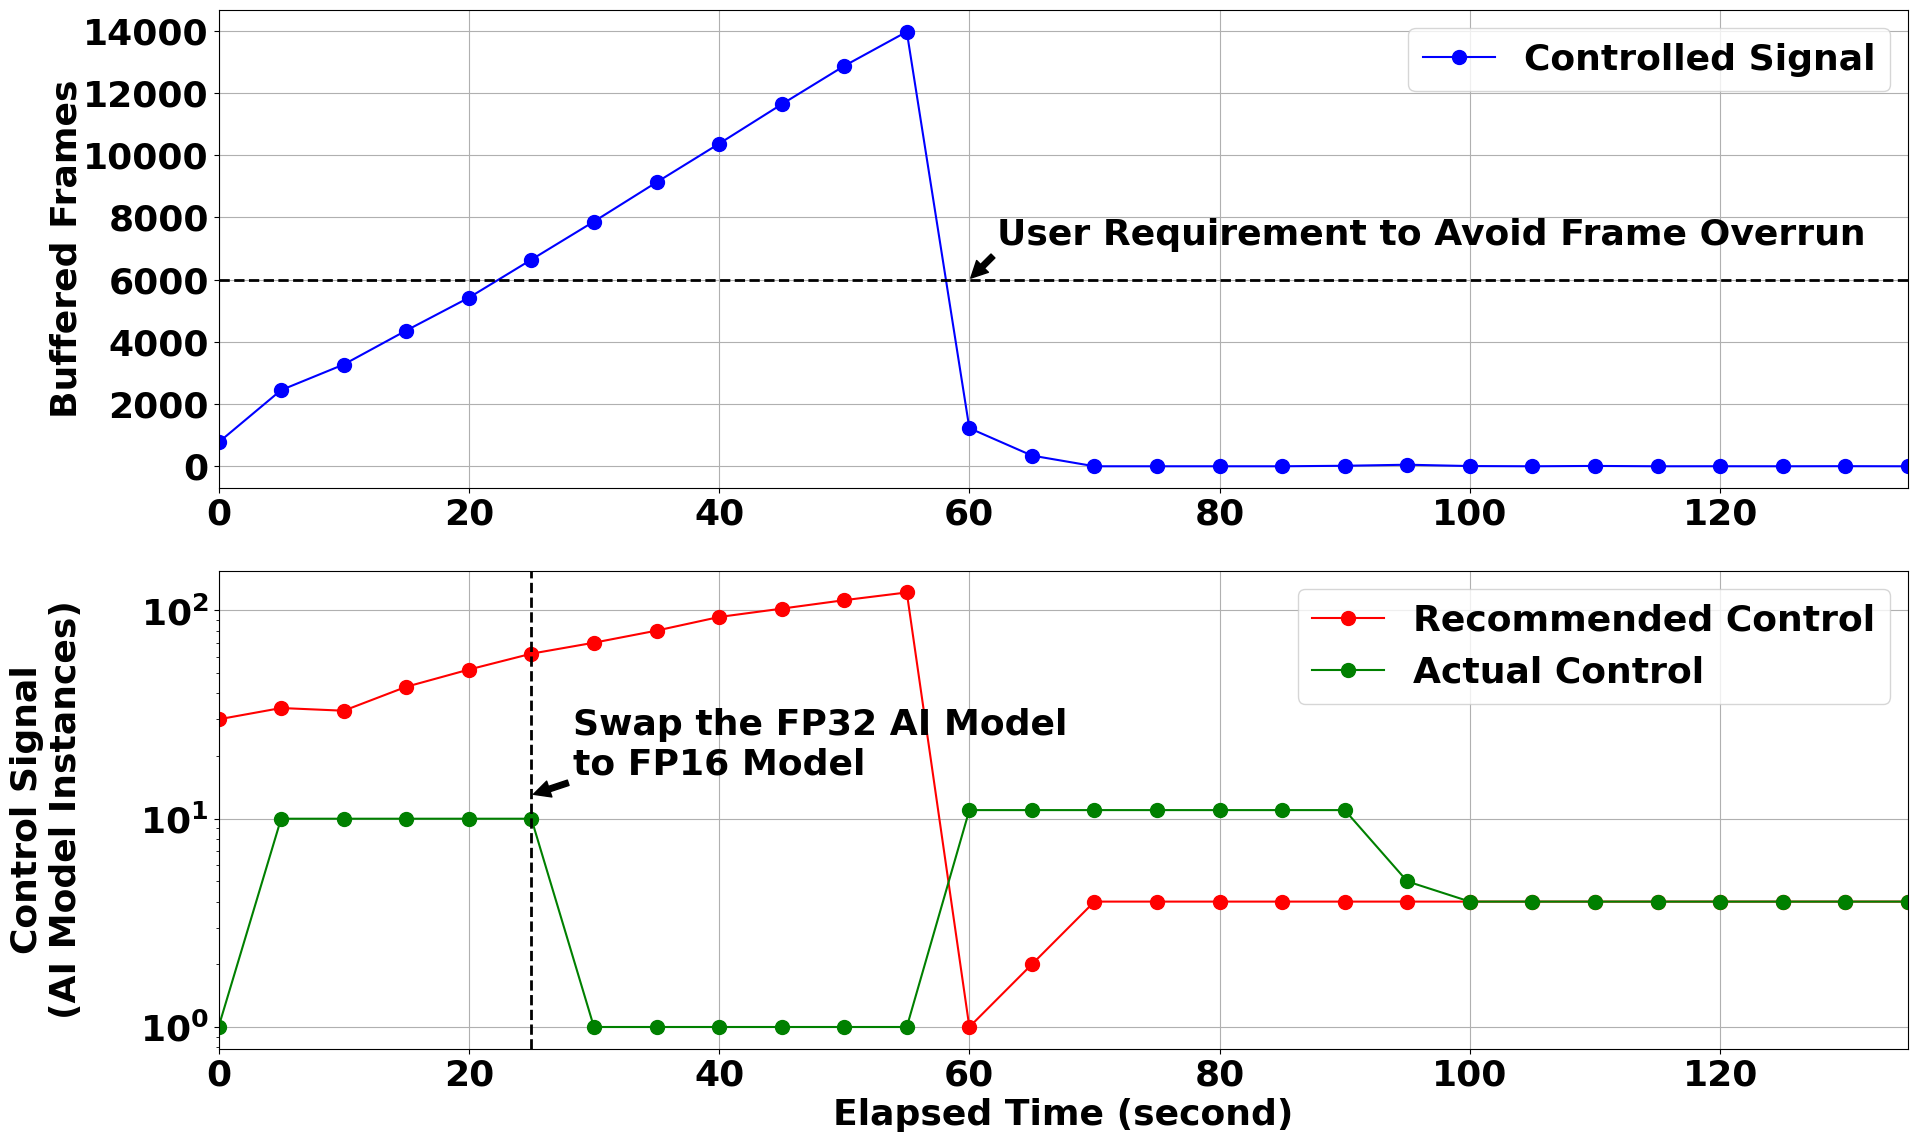

In [ ]:
plt.rcdefaults()
plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
plt.rcParams.update({'font.size': 26})

fig, axs = plt.subplots(2, 1, figsize=(20, 12))
framesqueued_df.index = pd.to_timedelta(framesqueued_df.index, unit='s')
framesqueued_df.resample('5s').sum().plot(ax=axs[0], color='b', marker='o', markersize=10, y='value', label="Controlled Signal")
axs[0].grid()
axs[0].yaxis.set_major_locator(plt.MultipleLocator(2000))
axs[0].set_xlabel("")
axs[0].set_ylabel("Buffered Frames\n(X-ray image)")
axs[0].axhline(y=6000, color='black', linestyle='--', linewidth=2)
axs[0].annotate(
    'User Requirement to Avoid Frame Overrun',
    xy=(pd.to_timedelta(60, 's').value, 6000),
    xycoords='data',
    xytext=(20, 25),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=26,
    fontweight='bold',
    color='black')

# Convert the index to TimedeltaIndex
replica_df.index = pd.to_timedelta(replica_df.index, unit='s')
actual_containers_df.index = pd.to_timedelta(actual_containers_df.index, unit='s')

replica_df["value"].resample('5s').sum().plot(ax=axs[1], color='r', marker='o', markersize=10, linestyle='-', label="Recommended Control")
actual_containers_df["value"].resample('5s').sum().plot(ax=axs[1], color='g', marker='o', markersize=10, linestyle='-', label="Actual Control")
axs[1].grid()
axs[1].legend(loc='upper right')
axs[1].set_xlabel("Elapsed Time (second)")
axs[1].set_yscale('log')
axs[1].set_ylabel("Control Signal\n(AI Model Instance)")
axs[1].axvline(x=pd.to_timedelta(25, 's').value, color='black', linestyle='--', linewidth=2)
axs[1].annotate(
    'Swap the FP32 AI Model\nto FP16 Model',
    xy=(pd.to_timedelta(25, 's').value, 13),
    xycoords='data',
    xytext=(30, 15),
    textcoords='offset points',
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=26,
    fontweight='bold')
for ax in axs:
    ax.yaxis.set_label_coords(-0.08, 0.5)
fig.tight_layout()
# Set x-axis to show seconds
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x / 1e9)}'))
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x / 1e9)}'))
fig.savefig(f"adaptive_control.pdf")
fig.savefig(f'adaptive_control.png', dpi=300)

In [35]:
framesqueued_df

,value,diff
elapsed_time,,
0 days 00:00:00,552.0,0.0
0 days 00:00:00,215.0,0.0
0 days 00:00:05,371.0,156.0
0 days 00:00:05,160.0,0.0
0 days 00:00:05,152.0,0.0
...,...,...
0 days 00:02:10,0.0,0.0
0 days 00:02:15,0.0,-3.0
0 days 00:02:15,0.0,0.0
